# Based on our custom MIMIC language model, train a 'DESCRIPTION' classifier

Make sure mimic_nlp_lm has been run first and sucessfully completed. That notebook builds the language model that allows classificiation to occur.

In [1]:
from fastai.text import *
from sklearn.model_selection import train_test_split
import glob
import gc

Setup filenames and paths

In [2]:
# pandas doesn't understand ~, so provide full path
base_path = Path.home() / 'mimic'

# files used during processing - all aggregated here
admissions_file = base_path/'ADMISSIONS.csv'
notes_file = base_path/'NOTEEVENTS.csv'

class_file = 'descr_cl_data.pickle'
notes_pickle_file = base_path/'noteevents.pickle'
lm_file = 'mimic_lm.pickle' # actual file is at base_path/lm_file but due to fastai function, have to pass file name separately
init_model_file = base_path/'descr_cl_head'
cycles_file = base_path/'descr_cl_num_iterations.pickle'
enc_file = 'mimic_fine_tuned_enc'
descr_ft_file = 'descr_cl_fine_tuned_'

Setup parameters for models

In [3]:
# original data set too large to work with in reasonable time due to limted GPU resources
pct_data_sample = 0.1
# how much to hold out for validation
valid_pct = 0.2
# for repeatability - different seed than used with language model
seed = 1776
# batch size of 96 GPU needs more than 16GB RAM
# batch size of 64 GPU uses 16GB RAM
# batch size of 48 GPU uses ??GB RAM
# changing batch size affects learning rate
bs=64

In [4]:
# if this doesn't free memory, can restart Python kernel.
# if that still doesn't work, try OS items mentioned here: https://docs.fast.ai/dev/gpu.html
def release_mem():
    gc.collect()
    torch.cuda.empty_cache()
release_mem()

In [5]:
orig_df = pd.DataFrame()
if os.path.isfile(notes_pickle_file):
    print('Loading noteevent pickle file')
    orig_df = pd.read_pickle(notes_pickle_file)
    print(orig_df.shape)
else:
    print('Could not find noteevent pickle file; creating it')
    # run this the first time to covert CSV to Pickle file
    orig_df = pd.read_csv(notes_file, low_memory=False, memory_map=True)
    orig_df.to_pickle(notes_pickle_file)

Loading noteevent pickle file
(2083180, 11)


Since seed is different, this should be quite different than the language model dataset.

Should I show details on how many records are in language model dataset?

In [6]:
df = orig_df.sample(frac=pct_data_sample, random_state=seed)

In [7]:
df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
1452901,1454539,14755,151669.0,2125-02-13,2125-02-13 05:37:00,2125-02-13 05:40:00,Nursing/other,Report,19585.0,NaN,Respiratory Care:\nPatient on PSV overnight of...
462929,466766,46041,176979.0,2160-06-02,2160-06-02 02:43:00,2160-06-02 02:57:32,Nursing,Nursing Progress Note,18654.0,NaN,"Shock, cardiogenic\n Assessment:\n Hemodyn..."
227661,237449,81883,118744.0,2143-10-28,NaN,NaN,ECG,Report,NaN,NaN,Compared to tracing #1 the patient's rate has ...
597361,603087,50450,147724.0,2191-09-20,2191-09-20 23:48:00,2191-09-20 23:48:27,Physician,Physician Attending Admission Note - MICU,16383.0,NaN,Chief Complaint: GI Bleed-melena and hemateme...
973311,962711,7287,108868.0,2152-06-02,2152-06-02 23:18:00,NaN,Radiology,PELVIS PORTABLE,NaN,NaN,[**2152-6-2**] 11:18 PM\n PELVIS PORTABLE ...


In [8]:
print('Unique Categories:', len(df.CATEGORY.unique()))
print('Unique Descriptions:', len(df.DESCRIPTION.unique()))

Unique Categories: 15
Unique Descriptions: 1708


Original section from lesson3
```python
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')
```

In [9]:
if os.path.isfile(base_path/lm_file):
    print('loading existing language model')
    lm = load_data(base_path, lm_file, bs=bs)
else:
    print('ERROR: language model file not found.')

loading existing language model


#### This is a very CPU and RAM intensive process - no GPU involved

Also, since there are a wide range of descriptions, not all descriptions present in the test set are in the validation set, so cannot learn all of them.

In [10]:
filename = base_path/class_file
if os.path.isfile(filename):
    data_cl = load_data(base_path, class_file, bs=bs)
else:
    # do I need a vocab here? test with and without...
    data_cl = (TextList.from_df(df, base_path, cols='TEXT', vocab=lm.vocab)
               #df has several columns; actual text is in column TEXT
               .split_by_rand_pct(valid_pct=valid_pct, seed=seed)
               #We randomly split and keep 20% for validation, set see for repeatability
               .label_from_df(cols='DESCRIPTION')
               #building classifier to automatically determine DESCRIPTION
               .databunch(bs=bs))
    data_cl.save(filename)

In [11]:
learn = text_classifier_learner(data_cl, AWD_LSTM, drop_mult=0.5)
learn.load_encoder(enc_file)

In [12]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


This rate will vary based on batch size. 

      For bs=96, 5e-2 worked well.
      For bs=48, looks like 1e-1 would work


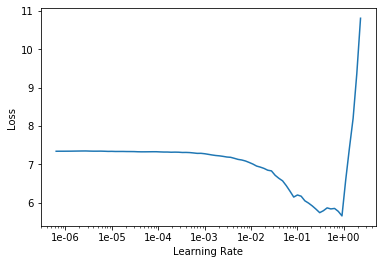

In [13]:
learn.recorder.plot()

Change learning rate based on results from the above plot

First unfrozen training results in approximately 90% accuracy with `learn.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))`

    Total time: 19:53

    epoch 	train_loss 	valid_loss 	accuracy 	time
        0 	0.563492 	0.433682 	0.904776 	19:53
        
By comparison, a smaller learning rate takes longer to get to similar accuracy (`learn.fit_one_cycle(1, 5e-2, moms=(0.8,0.7))`)

    Total time: 25:38

    epoch 	train_loss 	valid_loss 	accuracy 	time
        0 	0.451051 	0.413487 	0.909619 	25:38


In [15]:
if os.path.isfile(str(init_model_file) + '.pth'):
    learn.load(init_model_file)
    print('loaded initial learner')
else:
    print('Training new initial learner')
    learn.fit_one_cycle(3, 1e-1, moms=(0.8,0.7))
    print('Saving new learner')
    learn.save(init_model_file)
    print('Finished generating new learner')

Training new initial learner


epoch,train_loss,valid_loss,accuracy,time
0,0.563492,0.433682,0.904776,19:53


Saving new learner
Finished generating new learner


Now need to fine tune

In [16]:
learn = text_classifier_learner(data_cl, AWD_LSTM, drop_mult=0.5)
learn.load_encoder(enc_file)
learn.fit_one_cycle(1, 5e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.451051,0.413487,0.909619,25:38


In [ ]:
learn = text_classifier_learner(data_cl, AWD_LSTM, drop_mult=0.5)
learn.load_encoder(enc_file)
learn.fit_one_cycle(3, 1e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


In [ ]:
learn = text_classifier_learner(data_cl, AWD_LSTM, drop_mult=0.5)
learn.load_encoder(enc_file)
learn.fit_one_cycle(3, 5e-2, moms=(0.8,0.7))

In [ ]:
learn.unfreeze()

In [ ]:
learn.recorder.plot()

In [ ]:
release_mem()

In [ ]:
num_cycles = 5
prev_cycles = 0

file = descr_ft_file + str(prev_cycles)
learner_file = base_path/file
callback_save_file = str(learner_file) + '_auto'

learn.fit_one_cycle(num_cycles, 5e-3, moms=(0.8,0.7),
                    callbacks=[
                        callbacks.SaveModelCallback(learn, every='epoch', monitor='accuracy', name=callback_save_file),
                        # CSVLogger only logs when num_cycles are complete
                        callbacks.CSVLogger(learn, filename='descr_fine_tune_history', append=True)
                    ])
file = descr_ft_file + str(prev_cycles + num_cycles)
learner_file = base_path/file
learn.save(learner_file)

with open(cycles_file, 'wb') as f:
    pickle.dump(num_cycles + prev_cycles, f)
release_mem()